# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">1. Exploratory Data Analysis - LA Crime Forecasting</p>

# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Step 0: Problem Definition</p>

### Problem Statement

**This project predicts crime counts and types by geographic area and time window to enable optimised police resource allocation in Los Angeles.**

The core problem is crime forecasting for Los Angeles. The goal is to build a predictive system that answers two questions:
1. **How many crimes** will occur in a specific area during a given time window?
2. **What types of crimes** are those likely to be?

### Why This Matters

Police departments have limited resources. If we know that Central LA typically sees more vehicle thefts on Friday evenings while Hollywood has higher assault rates on weekends, patrol units can be deployed more effectively. This is not about predicting individual crimes, but about understanding patterns that inform resource allocation.

### Why Machine Learning?

Crime patterns are complex and influenced by multiple factors: time of day, day of week, geographic location, historical trends, and seasonal variations. Traditional rule-based approaches cannot capture these multi-dimensional interactions effectively. Machine learning can identify patterns across these dimensions and make predictions that adapt to changing trends.

# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Step 1: Decision Context</p>

### Who Makes the Decision?

Police commanders and resource planners who allocate patrol units across the 21 LAPD geographic areas.

### What Choice Are They Making?

- **Where** to deploy patrol units (which areas need more coverage)
- **When** to increase presence (which time windows are high-risk)
- **What type** of response to prepare (property crime vs violent crime requires different approaches)

### What Happens If the Model Is Wrong?

| Error Type | Consequence |
|------------|-------------|
| **Over-prediction** | Resources wasted in low-crime areas; other areas under-covered |
| **Under-prediction** | Insufficient presence during high-crime periods; slower response times |
| **Wrong crime type** | Mismatched response preparation (e.g., expecting property crime but facing violent crime) |

The cost of under-prediction is generally higher than over-prediction in public safety contexts, which will influence how we evaluate model performance.

# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Step 2: ML Paradigm Selection</p>

### Chosen Approach: Two-Stage Regression + Distribution

| Stage | Task | ML Approach | Justification |
|-------|------|-------------|---------------|
| **Stage 1** | Predict total crime count | Regression | Crime counts are continuous numeric values |
| **Stage 2** | Distribute across crime types | Proportion-based | Ensures mathematical consistency (types sum to total) |

### Why Not Other Approaches?

- **Classification**: Not suitable because we need counts, not categories
- **Multi-output regression**: Would not guarantee crime types sum to total
- **Time series (ARIMA)**: Less effective with spatial dimensions and multiple features
- **Deep learning**: Requires more data and offers less interpretability

### Why Two Stages?

1. **Mathematical consistency**: Crime type predictions always sum to the predicted total
2. **Robustness**: Stage 1 learns from aggregate patterns which are more stable
3. **Interpretability**: Clear separation between "how many" and "what types"
4. **Efficiency**: One model is faster to train than 21 separate models

# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Step 3: Data Understanding</p>

### Dataset Overview

**Source**: LAPD Crime Data from 2020 to Present (publicly available)

**Size**: Approximately 1 million crime records

**Time Span**: January 2020 to present (4+ years of data)

**Granularity**: Individual crime incidents

### Key Variables

| Variable | Description | Role |
|----------|-------------|------|
| `DATE OCC` | Date crime occurred | Temporal feature |
| `TIME OCC` | Time crime occurred (HHMM format) | Temporal feature |
| `AREA` | Geographic area code (1-21) | Spatial feature |
| `AREA NAME` | Name of police area | Spatial feature |
| `Crm Cd Desc` | Crime type description | Target (Stage 2) |
| `Vict Age` | Victim age | Contextual |
| `Vict Sex` | Victim sex | Contextual |
| `Premis Desc` | Premise description | Contextual |
| `Weapon Desc` | Weapon used | Contextual |
| `LAT`, `LON` | Coordinates | Spatial (not used for aggregation) |

### Known Limitations

1. **Reporting bias**: Only reported crimes are included; actual crime rates may differ
2. **Time placeholder issue**: Many records have TIME OCC = 1200 (placeholder value)
3. **Delayed reporting**: Some crimes reported days or weeks after occurrence
4. **Classification changes**: Crime categorisation may vary over time

# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Load Required Libraries</p>

In [3]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully")

Libraries loaded successfully


# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Step 4: Data Preparation - Initial Assessment</p>

### Load the Dataset

In [4]:
df = pd.read_csv('../data/Crime_Data_from_2020_to_Present.csv')
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (1004991, 28)


,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Used Cd,Weapon Desc,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,211507896,2021 Apr 11 12:00:00 AM,2020 Nov 07 12:00:00 AM,845,15,N Hollywood,1502,2,354,THEFT OF IDENTITY,0377,31,M,H,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,354.0,NaN,NaN,NaN,7800 BEEMAN AV,NaN,34.2124,-118.4092
1,201516622,2020 Oct 21 12:00:00 AM,2020 Oct 18 12:00:00 AM,1845,15,N Hollywood,1521,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",0416 0334 2004 1822 1414 0305 0319 0400,32,M,H,102.0,SIDEWALK,200.0,KNIFE WITH BLADE 6INCHES OR LESS,IC,Invest Cont,230.0,NaN,NaN,NaN,ATOLL AV,N GAULT,34.1993,-118.4203
2,240913563,2024 Dec 10 12:00:00 AM,2020 Oct 30 12:00:00 AM,1240,9,Van Nuys,933,2,354,THEFT OF IDENTITY,0377,30,M,W,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,354.0,NaN,NaN,NaN,14600 SYLVAN ST,NaN,34.1847,-118.4509
3,210704711,2020 Dec 24 12:00:00 AM,2020 Dec 24 12:00:00 AM,1310,7,Wilshire,782,1,331,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,0344,47,F,A,101.0,STREET,NaN,NaN,IC,Invest Cont,331.0,NaN,NaN,NaN,6000 COMEY AV,NaN,34.0339,-118.3747
4,201418201,2020 Oct 03 12:00:00 AM,2020 Sep 29 12:00:00 AM,1830,14,Pacific,1454,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),1300 0344 1606 2032,63,M,H,103.0,ALLEY,NaN,NaN,IC,Invest Cont,420.0,NaN,NaN,NaN,4700 LA VILLA MARINA,NaN,33.9813,-118.4350


### Dataset Info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004991 entries, 0 to 1004990
Data columns (total 28 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   DR_NO           1004991 non-null  int64  
 1   Date Rptd       1004991 non-null  object 
 2   DATE OCC        1004991 non-null  object 
 3   TIME OCC        1004991 non-null  int64  
 4   AREA            1004991 non-null  int64  
 5   AREA NAME       1004991 non-null  object 
 6   Rpt Dist No     1004991 non-null  int64  
 7   Part 1-2        1004991 non-null  int64  
 8   Crm Cd          1004991 non-null  int64  
 9   Crm Cd Desc     1004991 non-null  object 
 10  Mocodes         853372 non-null   object 
 11  Vict Age        1004991 non-null  int64  
 12  Vict Sex        860347 non-null   object 
 13  Vict Descent    860335 non-null   object 
 14  Premis Cd       1004975 non-null  float64
 15  Premis Desc     1004403 non-null  object 
 16  Weapon Used Cd  327247 non-null   fl

# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Check Missing Values</p>

In [6]:
# Check missing values for critical forecasting columns
critical_cols = ['DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Crm Cd Desc']
missing_df = df[critical_cols].isnull().sum().to_frame('Missing Count')
missing_df['Missing %'] = (missing_df['Missing Count'] / len(df) * 100).round(2)
missing_df

,Missing Count,Missing %
DATE OCC,0,0.0
TIME OCC,0,0.0
AREA,0,0.0
AREA NAME,0,0.0
Crm Cd Desc,0,0.0


### Missing Values Analysis

The critical columns for forecasting (DATE OCC, TIME OCC, AREA, Crm Cd Desc) have minimal missing values. This is expected as these are mandatory fields in police reports.

**Key observation**: TIME OCC shows low missing values, but we need to investigate the quality of non-missing values (placeholder issue).

### TIME OCC Placeholder Investigation

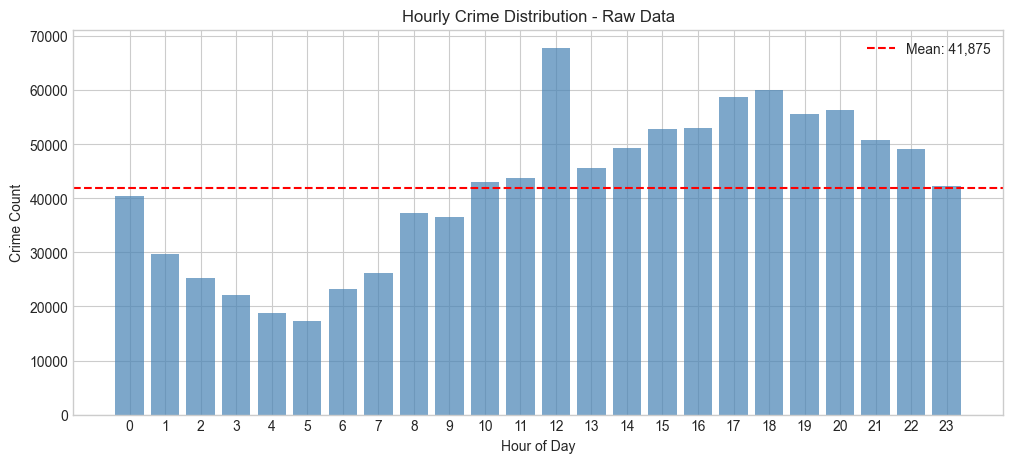


Hour 12 (noon) count: 67,813
Average hourly count: 41,875
Hour 12 is 1.6x the average


In [7]:
# Check distribution of TIME OCC values
df['hour'] = df['TIME OCC'].fillna(0).astype(int) // 100
hour_counts = df['hour'].value_counts().sort_index()

plt.figure(figsize=(12, 5))
plt.bar(hour_counts.index, hour_counts.values, color='steelblue', alpha=0.7)
plt.axhline(y=hour_counts.mean(), color='red', linestyle='--', label=f'Mean: {hour_counts.mean():,.0f}')
plt.xlabel('Hour of Day')
plt.ylabel('Crime Count')
plt.title('Hourly Crime Distribution - Raw Data')
plt.xticks(range(0, 24))
plt.legend()
plt.show()

print(f"\nHour 12 (noon) count: {hour_counts.get(12, 0):,}")
print(f"Average hourly count: {hour_counts.mean():,.0f}")
print(f"Hour 12 is {hour_counts.get(12, 0) / hour_counts.mean():.1f}x the average")

### Placeholder Time Finding

The spike at hour 12 (noon) is not realistic. When officers do not know the exact time of a crime, they often record 12:00 PM as a placeholder. This artificial concentration at noon would distort any temporal pattern analysis.

**Decision**: In the model training notebook, we will redistribute these placeholder times to create a realistic hourly distribution while tracking which records were imputed.

# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Check Duplicates</p>

In [8]:
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")
print(f"Percentage: {duplicates/len(df)*100:.2f}%")

Duplicate rows: 0
Percentage: 0.00%


# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Step 5: Exploratory Analysis</p>

# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Descriptive Statistics</p>

### Numerical and Categorical Column Separation

In [9]:
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")

Numerical columns (16): ['DR_NO', 'TIME OCC', 'AREA', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Vict Age', 'Premis Cd', 'Weapon Used Cd', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LAT', 'LON', 'hour']

Categorical columns (13): ['Date Rptd', 'DATE OCC', 'AREA NAME', 'Crm Cd Desc', 'Mocodes', 'Vict Sex', 'Vict Descent', 'Premis Desc', 'Weapon Desc', 'Status', 'Status Desc', 'LOCATION', 'Cross Street']


### Numerical Columns Description

In [10]:
df[numerical_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
DR_NO,1004991.0,2.202215e+08,1.319718e+07,817.0000,2.106169e+08,2.209159e+08,2.311103e+08,2.521041e+08
TIME OCC,1004991.0,1.339900e+03,6.510613e+02,1.0000,9.000000e+02,1.420000e+03,1.900000e+03,2.359000e+03
AREA,1004991.0,1.069174e+01,6.110255e+00,1.0000,5.000000e+00,1.100000e+01,1.600000e+01,2.100000e+01
Rpt Dist No,1004991.0,1.115633e+03,6.111605e+02,101.0000,5.870000e+02,1.139000e+03,1.613000e+03,2.199000e+03
Part 1-2,1004991.0,1.400348e+00,4.899691e-01,1.0000,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00
Crm Cd,1004991.0,5.001568e+02,2.052731e+02,110.0000,3.310000e+02,4.420000e+02,6.260000e+02,9.560000e+02
Vict Age,1004991.0,2.891706e+01,2.199272e+01,-4.0000,0.000000e+00,3.000000e+01,4.400000e+01,1.200000e+02
Premis Cd,1004975.0,3.056201e+02,2.193021e+02,101.0000,1.010000e+02,2.030000e+02,5.010000e+02,9.760000e+02
Weapon Used Cd,327247.0,3.639553e+02,1.237345e+02,101.0000,3.110000e+02,4.000000e+02,4.000000e+02,5.160000e+02
Crm Cd 1,1004980.0,4.999174e+02,2.050736e+02,110.0000,3.310000e+02,4.420000e+02,6.260000e+02,9.560000e+02


### Key Categorical Columns

In [11]:
key_cat_cols = ['AREA NAME', 'Crm Cd Desc', 'Premis Desc', 'Status Desc']
for col in key_cat_cols:
    if col in df.columns:
        print(f"\n{col}: {df[col].nunique()} unique values")
        print(df[col].value_counts().head(5))


AREA NAME: 21 unique values
AREA NAME
Central        69670
77th Street    61758
Pacific        59514
Southwest      57441
Hollywood      52429
Name: count, dtype: int64

Crm Cd Desc: 140 unique values
Crm Cd Desc
VEHICLE - STOLEN                                           115190
BATTERY - SIMPLE ASSAULT                                    74839
BURGLARY FROM VEHICLE                                       63517
THEFT OF IDENTITY                                           62537
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)     61092
Name: count, dtype: int64

Premis Desc: 306 unique values
Premis Desc
STREET                                          261284
SINGLE FAMILY DWELLING                          163654
MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)    119011
PARKING LOT                                      69147
OTHER BUSINESS                                   47647
Name: count, dtype: int64

Status Desc: 6 unique values
Status Desc
Invest Cont     802862
Adult Other     1098

# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Temporal Pattern Analysis</p>

### Parse Date Features

In [12]:
# Parse dates
df['date_occ'] = pd.to_datetime(df['DATE OCC'], format='mixed', errors='coerce')
df['year'] = df['date_occ'].dt.year
df['month'] = df['date_occ'].dt.month
df['day_of_week'] = df['date_occ'].dt.dayofweek
df['day_name'] = df['date_occ'].dt.day_name()
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

print(f"Date range: {df['date_occ'].min()} to {df['date_occ'].max()}")

Date range: 2020-01-01 00:00:00 to 2025-05-29 00:00:00


### Weekly Crime Patterns

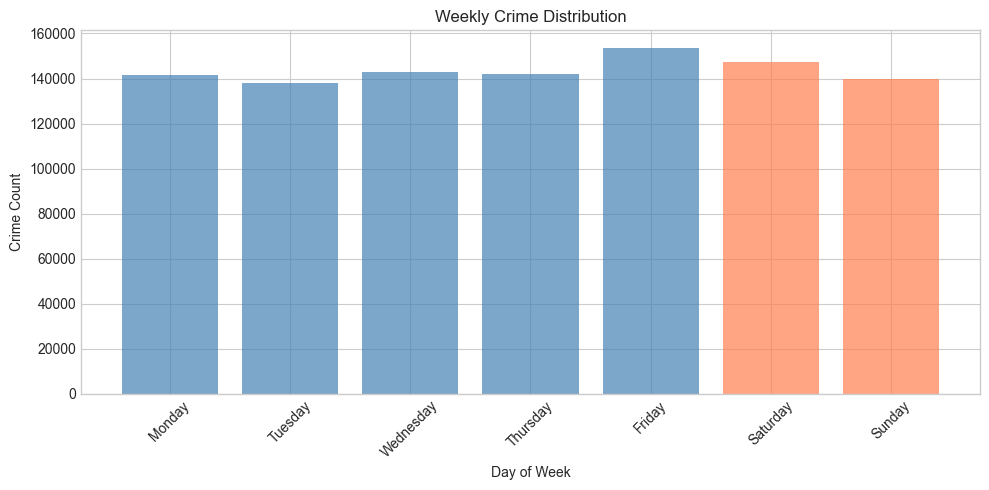


Average daily crimes - Weekday: 533, Weekend: 541


In [13]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_crimes = df['day_name'].value_counts().reindex(day_order)

plt.figure(figsize=(10, 5))
colors = ['steelblue' if day not in ['Saturday', 'Sunday'] else 'coral' for day in day_order]
plt.bar(daily_crimes.index, daily_crimes.values, color=colors, alpha=0.7)
plt.xlabel('Day of Week')
plt.ylabel('Crime Count')
plt.title('Weekly Crime Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

weekend_avg = df[df['is_weekend']==1].groupby('date_occ').size().mean()
weekday_avg = df[df['is_weekend']==0].groupby('date_occ').size().mean()
print(f"\nAverage daily crimes - Weekday: {weekday_avg:.0f}, Weekend: {weekend_avg:.0f}")

### Monthly Crime Patterns

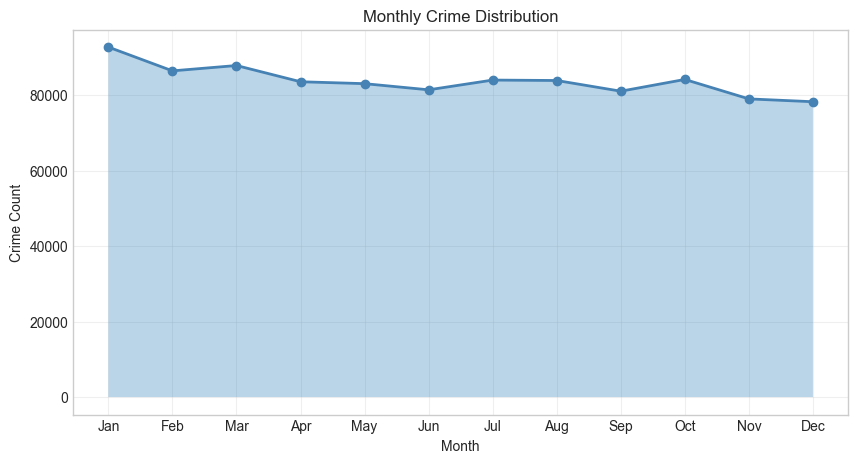

In [14]:
monthly_crimes = df.groupby('month').size()

plt.figure(figsize=(10, 5))
plt.plot(monthly_crimes.index, monthly_crimes.values, marker='o', linewidth=2, color='steelblue')
plt.fill_between(monthly_crimes.index, monthly_crimes.values, alpha=0.3)
plt.xlabel('Month')
plt.ylabel('Crime Count')
plt.title('Monthly Crime Distribution')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, alpha=0.3)
plt.show()

### Yearly Trend

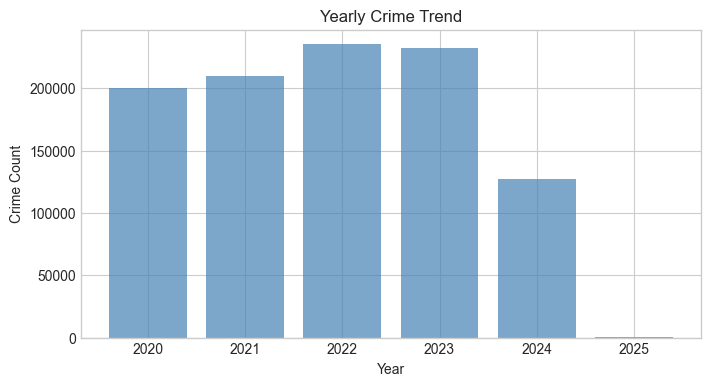

In [15]:
yearly_crimes = df.groupby('year').size()

plt.figure(figsize=(8, 4))
plt.bar(yearly_crimes.index.astype(str), yearly_crimes.values, color='steelblue', alpha=0.7)
plt.xlabel('Year')
plt.ylabel('Crime Count')
plt.title('Yearly Crime Trend')
plt.show()

### Temporal Pattern Insights

**Key findings:**
1. **Weekly patterns**: Crime counts are relatively stable across weekdays, with slight variations on weekends
2. **Monthly patterns**: Some seasonal variation observed, with certain months showing higher crime counts
3. **Time of day**: Strong patterns exist (afternoon/evening peaks) but require placeholder time correction

These temporal patterns indicate that time-based features will be valuable for the forecasting model.

# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Spatial Distribution Analysis</p>

### Crime Distribution by Area

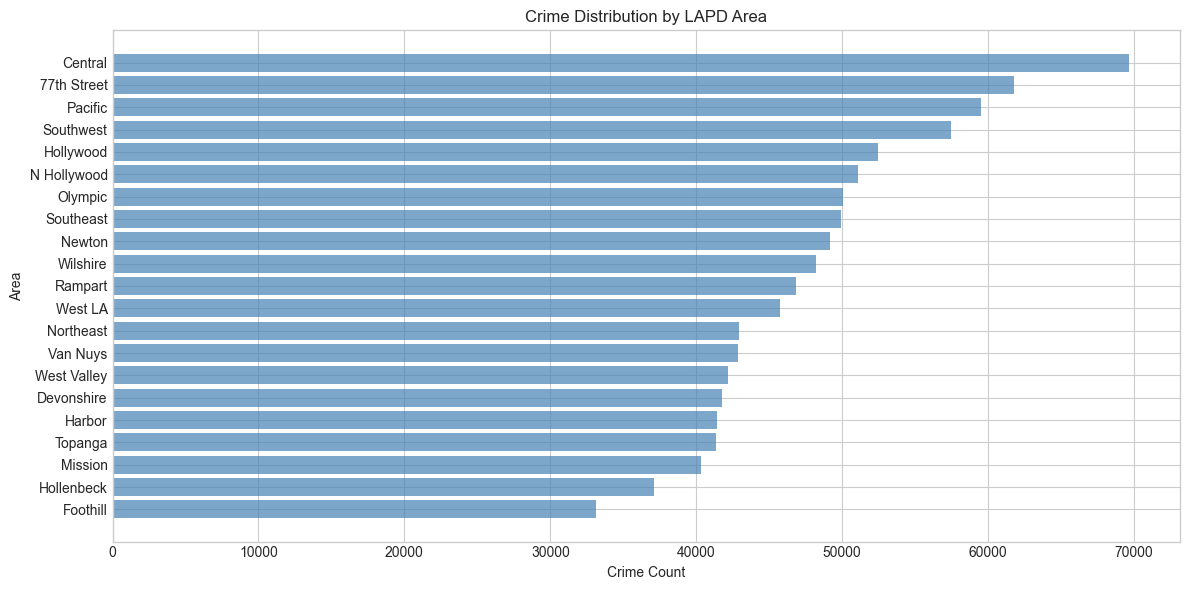


Total areas: 21
Top 5 areas account for 29.9% of crimes


In [16]:
area_crimes = df['AREA NAME'].value_counts()

plt.figure(figsize=(12, 6))
plt.barh(area_crimes.index[::-1], area_crimes.values[::-1], color='steelblue', alpha=0.7)
plt.xlabel('Crime Count')
plt.ylabel('Area')
plt.title('Crime Distribution by LAPD Area')
plt.tight_layout()
plt.show()

print(f"\nTotal areas: {area_crimes.shape[0]}")
print(f"Top 5 areas account for {area_crimes.head(5).sum() / area_crimes.sum() * 100:.1f}% of crimes")

### Area Crime Concentration

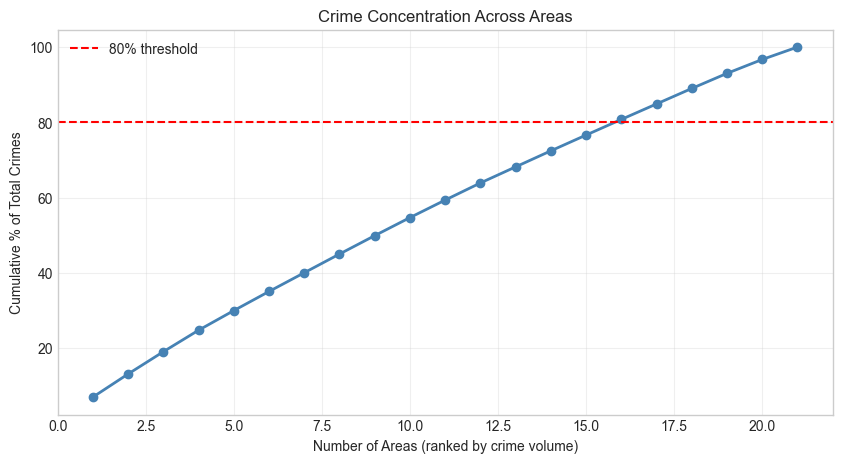

In [17]:
# Cumulative distribution
area_crimes_sorted = area_crimes.sort_values(ascending=False)
cumulative_pct = area_crimes_sorted.cumsum() / area_crimes_sorted.sum() * 100

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_pct)+1), cumulative_pct.values, marker='o', linewidth=2, color='steelblue')
plt.axhline(y=80, color='red', linestyle='--', label='80% threshold')
plt.xlabel('Number of Areas (ranked by crime volume)')
plt.ylabel('Cumulative % of Total Crimes')
plt.title('Crime Concentration Across Areas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Spatial Pattern Insights

**Key findings:**
1. **Uneven distribution**: Crime is not uniformly distributed; some areas have significantly higher volumes
2. **Concentration**: A subset of areas accounts for the majority of crimes
3. **Implication**: Area-based features will be important for the model; high-crime areas may need different treatment

This geographic variation justifies using area as a key feature in our forecasting model.

# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Crime Type Analysis</p>

### Top Crime Types

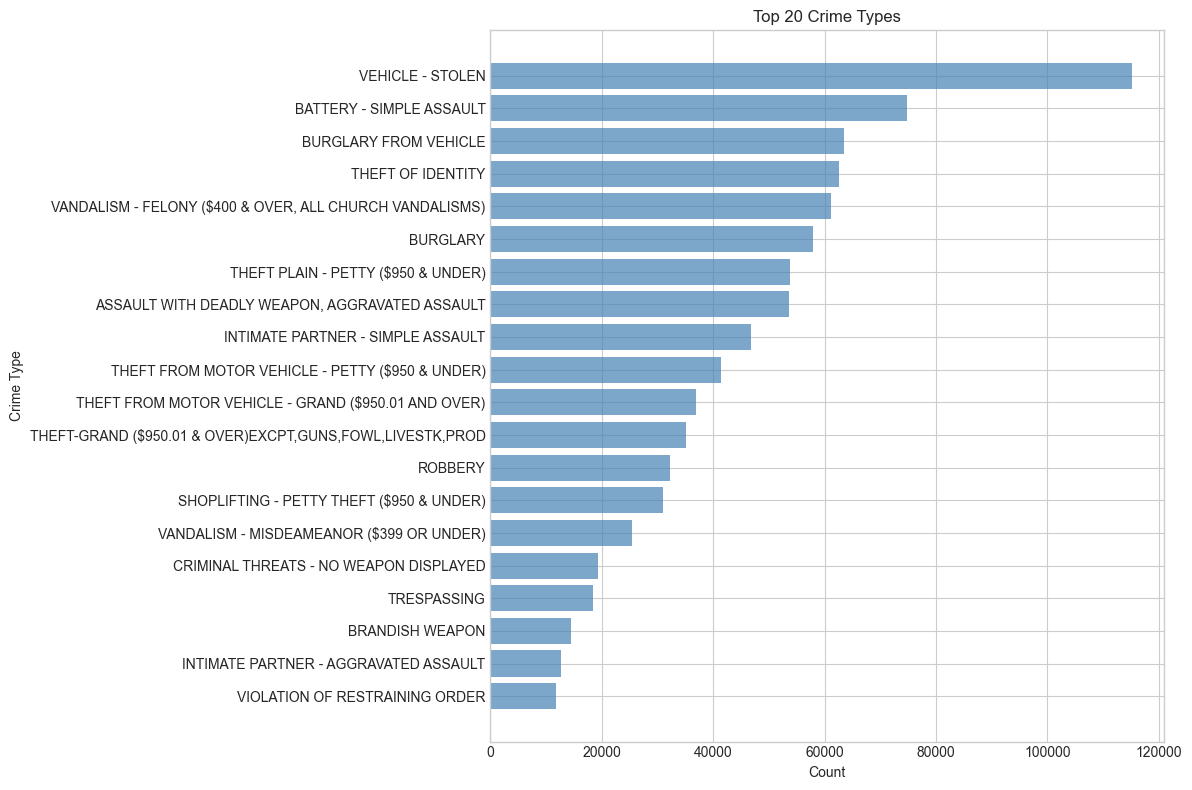


Total crime types: 140
Top 20 account for 86.3% of all crimes


In [18]:
crime_types = df['Crm Cd Desc'].value_counts()
top_20 = crime_types.head(20)

plt.figure(figsize=(12, 8))
plt.barh(top_20.index[::-1], top_20.values[::-1], color='steelblue', alpha=0.7)
plt.xlabel('Count')
plt.ylabel('Crime Type')
plt.title('Top 20 Crime Types')
plt.tight_layout()
plt.show()

print(f"\nTotal crime types: {crime_types.shape[0]}")
print(f"Top 20 account for {top_20.sum() / crime_types.sum() * 100:.1f}% of all crimes")

### Crime Type Distribution

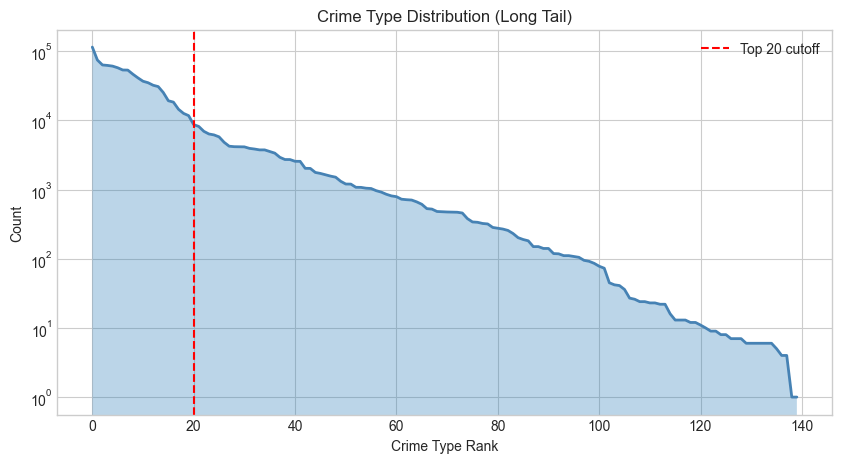

In [19]:
# Show the long tail
crime_type_counts = crime_types.values

plt.figure(figsize=(10, 5))
plt.plot(range(len(crime_type_counts)), crime_type_counts, linewidth=2, color='steelblue')
plt.fill_between(range(len(crime_type_counts)), crime_type_counts, alpha=0.3)
plt.axvline(x=20, color='red', linestyle='--', label='Top 20 cutoff')
plt.xlabel('Crime Type Rank')
plt.ylabel('Count')
plt.title('Crime Type Distribution (Long Tail)')
plt.legend()
plt.yscale('log')
plt.show()

### Crime Type Insights

**Key findings:**
1. **Long tail distribution**: A few crime types dominate; many types are rare
2. **Top 20 coverage**: The top 20 crime types cover the vast majority of incidents
3. **Categorisation strategy**: We will use Top 20 + "Others" bucket for practical prediction

This distribution justifies our approach of focusing on the top crime types and grouping rare types.

# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Correlation Analysis</p>

### Correlation Heatmap for Numerical Variables

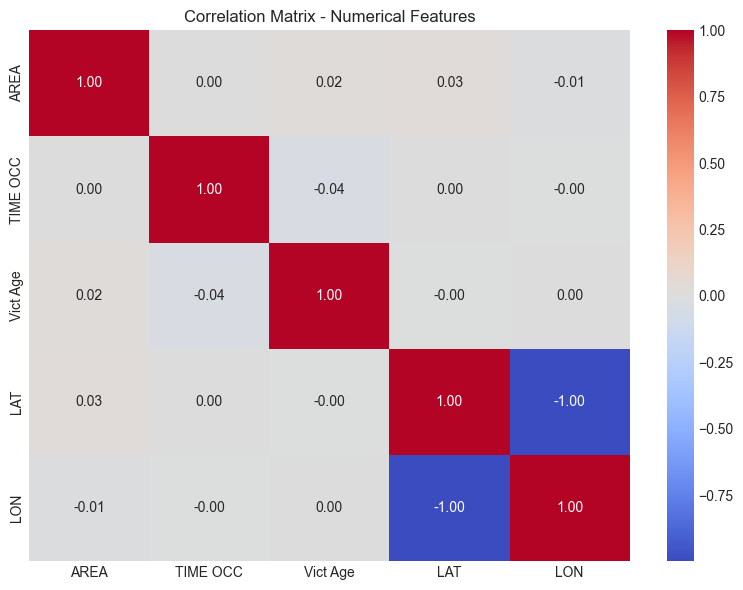

In [20]:
# Select relevant numerical columns for correlation
corr_cols = ['AREA', 'TIME OCC', 'Vict Age', 'LAT', 'LON']
corr_cols = [c for c in corr_cols if c in df.columns]

corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix - Numerical Features')
plt.tight_layout()
plt.show()

### Area-Time Interaction

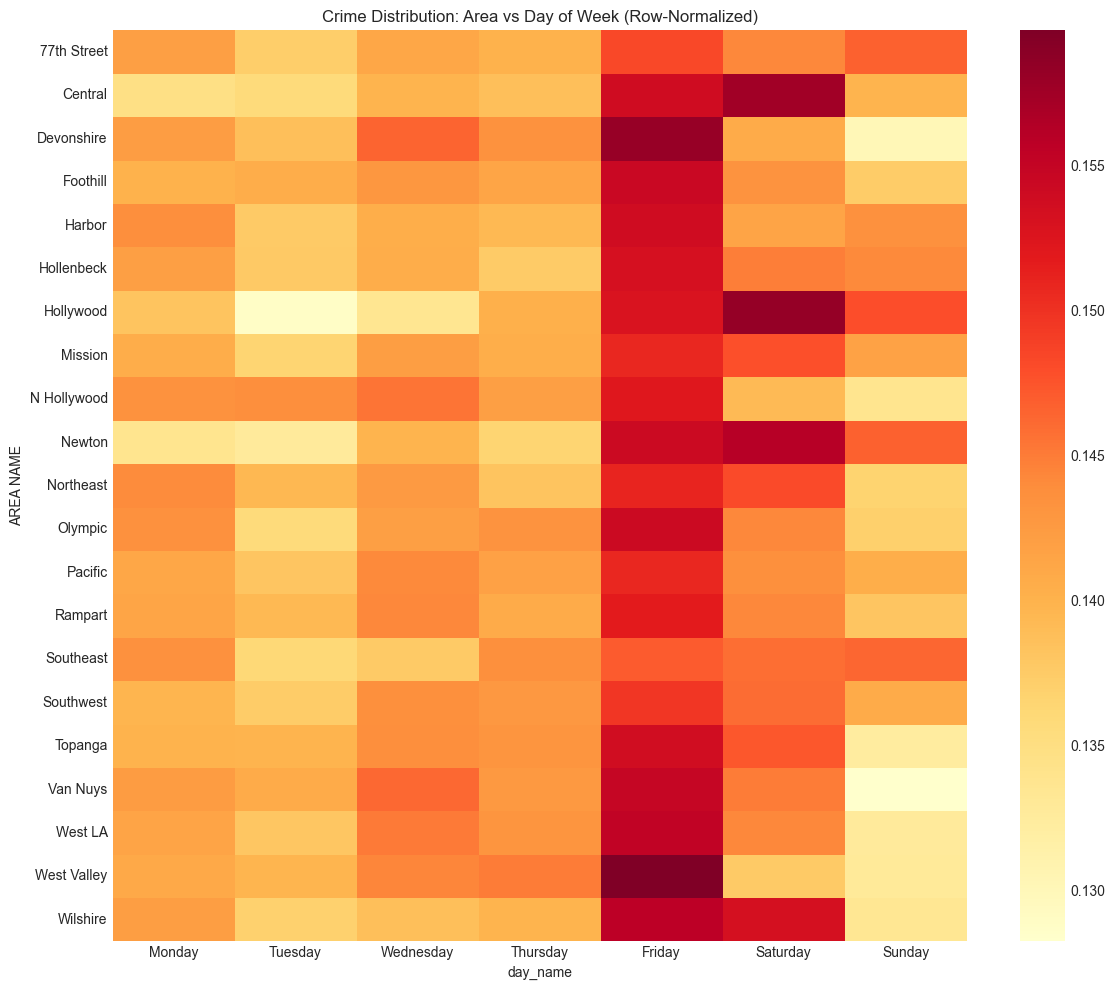

In [21]:
# Create pivot table: Area vs Day of Week
area_day_pivot = pd.crosstab(df['AREA NAME'], df['day_name'])
area_day_pivot = area_day_pivot[day_order]  # Reorder columns

# Normalize by row to show patterns
area_day_norm = area_day_pivot.div(area_day_pivot.sum(axis=1), axis=0)

plt.figure(figsize=(12, 10))
sns.heatmap(area_day_norm, cmap='YlOrRd', annot=False)
plt.title('Crime Distribution: Area vs Day of Week (Row-Normalized)')
plt.tight_layout()
plt.show()

### Correlation Insights

**Key findings:**
1. **Spatial features**: LAT and LON are correlated (geographic clustering)
2. **Area-time interactions**: Different areas show different weekly patterns
3. **Feature engineering implication**: Area-time interaction features may improve model performance

# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">EDA Summary and Key Findings</p>

### Summary of Findings

| Aspect | Finding | Implication for Modelling |
|--------|---------|---------------------------|
| **Data Quality** | TIME OCC has placeholder values at 12:00 PM | Requires smart imputation before modelling |
| **Missing Values** | Critical columns have minimal missing data | Data is suitable for modelling |
| **Temporal Patterns** | Clear hourly, daily, and monthly patterns | Time-based features will be predictive |
| **Spatial Patterns** | Crime concentrated in specific areas | Area is a key feature; may need area-specific models |
| **Crime Types** | Long-tail distribution; Top 20 dominate | Use Top 20 + Others categorisation |
| **Interactions** | Area-time patterns vary | Include interaction features |

### Recommended Feature Engineering

Based on EDA findings, the following features should be created:

1. **Temporal features**: year, month, day_of_week, hour, time_block, is_weekend
2. **Spatial features**: area (encoded)
3. **Lag features**: crime_count_lag1, crime_count_lag7 (capture recent history)
4. **Rolling averages**: 7-day and 30-day rolling means (capture trends)
5. **Data quality flag**: is_time_imputed (track imputed records)

### Model Selection Rationale

Based on the data characteristics:

- **Gradient boosting models (XGBoost, RandomForest)** are recommended because:
  - Handle mixed feature types well
  - Capture non-linear relationships
  - Provide feature importance for interpretability
  - Robust to outliers
  
- **Two-stage approach** is recommended because:
  - Ensures mathematical consistency (crime types sum to total)
  - Stage 1 regression is more stable than multi-output prediction
  - Clear separation of concerns aids interpretability

### Next Steps

Proceed to **Notebook 2: Model Training** where we will:
1. Preprocess data (handle TIME OCC placeholders)
2. Aggregate to time windows
3. Engineer features
4. Train and compare RandomForest vs XGBoost
5. Tune the best performing model
6. Implement two-stage prediction